In [58]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

In [59]:
t = np.arange(0, 10, 0.005)

#random data on x-axis
A1  = 5*np.random.rand()
f1  = 10*np.random.rand()+5
b1  = 20*np.random.rand()

ceta1 = 2*np.random.rand()*np.pi

signal1 = A1 * np.sin(f1 * t + ceta1) + b1

#random data on x-axis
A2  = 5*np.random.rand()
f2  = 10*np.random.rand()+20
b2  = 20*np.random.rand()
ceta2 = 2*np.random.rand()*np.pi

signal2 = A2 * np.cos(f2 * t + ceta2) + b2

y = signal1 + signal2

print(f"A1 = {A1}, f1 = {f1} , ceta1 = {ceta1} b1= {b1}")
print(f"A2 = {A2}, f1 = {f2} , ceta2 = {ceta2} b2= {b2}")

A1 = 4.230968827279829, f1 = 8.017577110274495 , ceta1 = 2.5540139867578477 b1= 0.11838228358739267
A2 = 1.0919696782741801, f1 = 26.664131405004785 , ceta2 = 0.7954058500554182 b2= 12.140892109687101


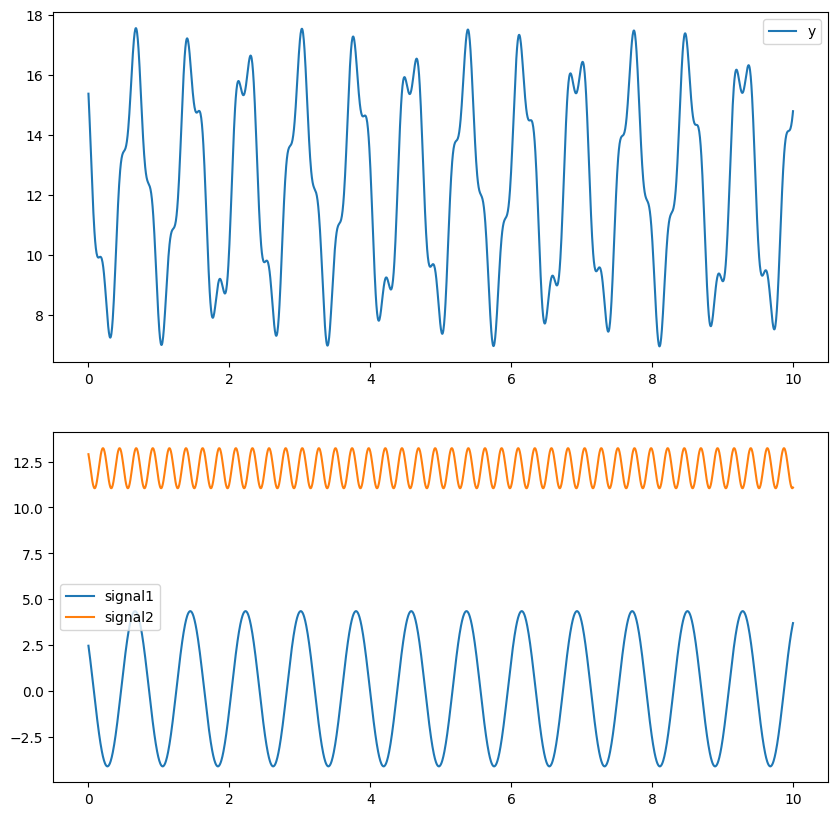

In [60]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(t,y)
plt.legend(['y'])
plt.subplot(2,1,2)

plt.plot(t,signal1,t,signal2)
plt.legend(['signal1','signal2'])

In [61]:
y

array([15.3690743 , 15.11562085, 14.84702248, ..., 14.55415427,
       14.66295228, 14.7853541 ], shape=(2000,))

In [62]:
class CurveFittingModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Improved Initialization to avoid local minima (Straight Line)
        self.A1 = nn.Parameter(torch.randn(1, requires_grad=True))
        self.A2 = nn.Parameter(torch.randn(1, requires_grad=True))
        # Initialize frequencies to plausible range (10-20Hz) instead of ~0
        self.f1 = nn.Parameter(torch.tensor([10.0], requires_grad=True))
        self.f2 = nn.Parameter(torch.tensor([20.0], requires_grad=True))
        self.theta1 = nn.Parameter(torch.rand(1, requires_grad=True) * 6.28)
        self.theta2 = nn.Parameter(torch.rand(1, requires_grad=True) * 6.28)
        self.b1 = nn.Parameter(torch.rand(1, requires_grad=True) * 10)
        self.b2 = nn.Parameter(torch.rand(1, requires_grad=True) * 10)

    def forward(self, t):
        # โครงสร้างทางคณิตศาสตร์ของคลื่นผสมตามโจทย์
        signal1 = self.A1 * torch.sin(self.f1 * t + self.theta1) + self.b1
        signal2 = self.A2 * torch.cos(self.f2 * t + self.theta2) + self.b2
        return signal1 + signal2

# สร้าง object ของโมเดล
model = CurveFittingModel()

In [63]:
criterion = nn.MSELoss()
# Adam มักจะทำงานได้ดี lr=0.1 เป็นจุดเริ่มต้นที่ดีสำหรับปัญหา curve fitting
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [64]:
# 1. แปลงข้อมูล numpy ให้เป็น PyTorch tensors
t_tensor = torch.from_numpy(t).float()
y_tensor = torch.from_numpy(y).float()

# Random Restart Strategy applied
n_restarts = 10
best_loss = float('inf')
best_state = None

print("Searching for best initialization...")

for attempt in range(n_restarts):
    model = CurveFittingModel()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # Quick training to test convergence
    for i in range(1000):
        optimizer.zero_grad()
        y_pred = model(t_tensor)
        loss = criterion(y_pred, y_tensor)
        loss.backward()
        optimizer.step()

    print(f"Attempt {attempt+1}: Loss = {loss.item():.4f}")
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_state = model.state_dict()
        if best_loss < 20:
            print("Found good start! Stopping search.")
            break

print(f"Best Loss found: {best_loss:.4f}")
model.load_state_dict(best_state)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 5000
loss_history = []

print("Starting fine-tuning...")
for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model(t_tensor)
    loss = criterion(y_pred, y_tensor)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if i % 500 == 0:
        print(f"Fine-tuning Epoch {i}: Loss = {loss.item():.4f}")

print("Training finished.")

Searching for best initialization...
Attempt 1: Loss = 9.3393
Found good start! Stopping search.
Best Loss found: 9.3393
Starting fine-tuning...
Fine-tuning Epoch 0: Loss = 9.3393
Fine-tuning Epoch 500: Loss = 9.3393
Fine-tuning Epoch 1000: Loss = 9.3393
Fine-tuning Epoch 1500: Loss = 9.3393
Fine-tuning Epoch 2000: Loss = 9.3393
Fine-tuning Epoch 2500: Loss = 9.3393
Fine-tuning Epoch 3000: Loss = 9.3393
Fine-tuning Epoch 3500: Loss = 9.3393
Fine-tuning Epoch 4000: Loss = 9.3393
Fine-tuning Epoch 4500: Loss = 9.3393
Training finished.


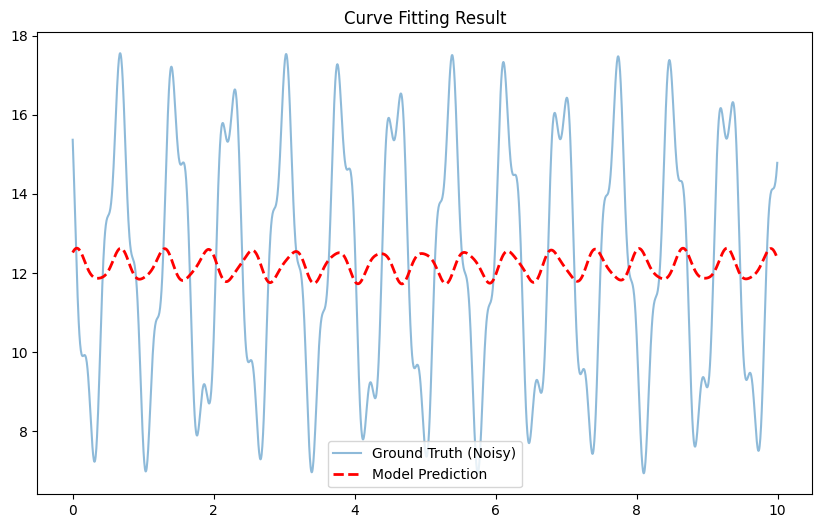

Learned Parameters:
A1: 0.3797, f1: 10.2265, theta1: 0.9484, b1: 6.1346
A2: 0.0717, f2: 19.7358, theta2: -1.0973, b2: 6.0433


In [65]:
# 1. เอาค่าพยากรณ์ล่าสุดออกมา
with torch.no_grad():
   y_predicted = model(t_tensor).numpy()

# 2. พลอตกราฟเทียบกัน
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Ground Truth (Noisy)', alpha=0.5)
plt.plot(t, y_predicted, 'r--', label='Model Prediction', linewidth=2)
plt.legend()
plt.title("Curve Fitting Result")
plt.show()

# 3. ปริ้นค่าพารามิเตอร์ที่เรียนรู้ได้
# หมายเหตุ: โมเดลอาจจะสลับคู่ A1/A2 หรือ f1/f2 ก็ได้ ซึ่งเป็นเรื่องปกติ ขอแค่กราฟตรงกันก็ถือว่าถูกต้องครับ
print("Learned Parameters:")
print(f"A1: {model.A1.item():.4f}, f1: {model.f1.item():.4f}, theta1: {model.theta1.item():.4f}, b1: {model.b1.item():.4f}")
print(f"A2: {model.A2.item():.4f}, f2: {model.f2.item():.4f}, theta2: {model.theta2.item():.4f}, b2: {model.b2.item():.4f}")